In [2]:
import numpy as np 
import pandas as pd
import sqlite3
import matplotlib.pyplot as plt
from pathlib import Path

# Import data from csv and create a database (including table) and a dataframe.

Path('maternity_risk_data.db').touch()
#con = sqlite3.connect("/kaggle/working/maternity_risk_data.db")
con = sqlite3.connect("Pregnancy_Risk.db")
cur = con.cursor()
cur.execute('''CREATE TABLE IF NOT EXISTS risk_tb (Age, SystolicBP, DiastolicBP, BS, BodyTemp, HeartRate, RiskLevel)''')
maternity_risk = pd.read_csv('pregnancy-risk.csv')
new_index = [i + 1 for i in maternity_risk.index]
maternity_risk.insert(1, 'index_col', new_index) # Add a column for index since it was missing from original dataset. 
maternity_risk.to_sql('risk_tb', con, if_exists='replace', index=False)
risk_df = pd.read_sql('''SELECT * FROM risk_tb''',con)
risk_df

,Age,index_col,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,1,130,80,15.0,98.0,86,high risk
1,35,2,140,90,13.0,98.0,70,high risk
2,29,3,90,70,8.0,100.0,80,high risk
3,30,4,140,85,7.0,98.0,70,high risk
4,35,5,120,60,6.1,98.0,76,low risk
...,...,...,...,...,...,...,...,...
1009,22,1010,120,60,15.0,98.0,80,high risk
1010,55,1011,120,90,18.0,98.0,60,high risk
1011,35,1012,85,60,19.0,98.0,86,high risk
1012,43,1013,120,90,18.0,98.0,70,high risk


In [4]:
# Checking for the null value.

print(risk_df.isna().sum())

# Counting the number of null values.

print(risk_df.isna().sum().sum())

Age            0
index_col      0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64
0


In [5]:
# Assign age designations to all records and calculate percentage for each.

age_df = pd.read_sql('''WITH desig AS
                          (SELECT Age, 
                                  CASE 
                                    WHEN Age <= 12 THEN "Children"
                                    WHEN Age <= 17 THEN "Adolescents"
                                    WHEN Age <= 44 THEN "Pre-menopausal Adults"
                                    WHEN Age <= 55 THEN "Menopausal Adults"
                                    WHEN Age <= 64 THEN "Post-menopausal Adults"
                                    ELSE "Older adults"
                                  END AS Age_designation
                          FROM risk_tb)
                          
                        SELECT Age_designation, COUNT(*) age_count, ROUND((1.0*COUNT(*)/(SELECT COUNT(*) FROM risk_tb)*100), 1) || "%" percentage
                        FROM desig
                        GROUP BY Age_designation
                        ORDER BY age_count
                        ;
                    ''', con)

age_df

,Age_designation,age_count,percentage
0,Older adults,5,0.5%
1,Children,39,3.8%
2,Post-menopausal Adults,40,3.9%
3,Menopausal Adults,138,13.6%
4,Adolescents,154,15.2%
5,Pre-menopausal Adults,638,62.9%


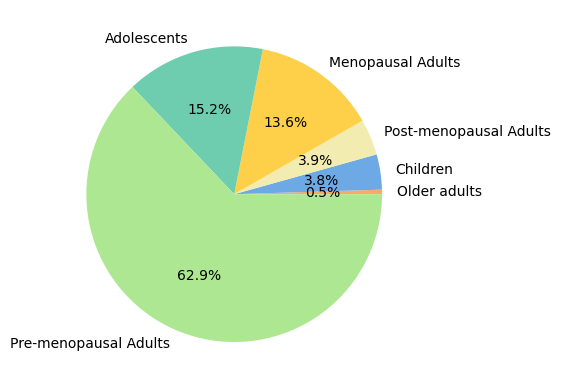

In [6]:
# Make a pie chart.

age_colors = ["#FDA769","#6DA9E4", "#F3ECB0", "#FED049", "#6ECCAF", "#ADE792"]
plt.pie(age_df["age_count"], labels=age_df["Age_designation"], colors=age_colors, autopct=lambda p: '{:.1f}%'.format(p))
plt.show() 

The patients featured in the study were from various age groups. Age designations were given based on National Institute of Health (NIH) guide (NIH, 2022). More than half of the patients were pre-menopausal adults (62.9% or 638 patients, 18-44 years old), followed by adolescents (15.2%, 13-17 years old) and menopausal adults (13.6%, 45-55 years old, [NIH, 2021]). There were a small number of post-menopausal adults (3.9%, 56-64 years old), children (3.8%, 10-12 years old) and older adults (0.5% or 5 patients, 65 and older).

Age plays an important role in pregnancy health. Women who get pregnant later in life have higher risks for complications, e.g. after age 40 there is an increased risk for preeclampsia and risk for the health of the fetus (The American College of Obstetricians and Gynecologists, 2023). Menopause transition could start around the age of 44 but it varies among individuals depending on factors such as life stles and ethnicity. During first 12 months after a woman's last period, there is still a possibility of natural pregnancy (NIH, 2021). Then after menopause when the hormonal levels are too low and ovaries do not release any eggs, women could get pregnant via artificial methods such as in vitro fertilisation (IVF).

In order to build a model, we need to ensure that there are no correlations among variables, i.e. no multicolinearity. First, we can create a pairplot using seaborn to give us an overview of variable relationships.

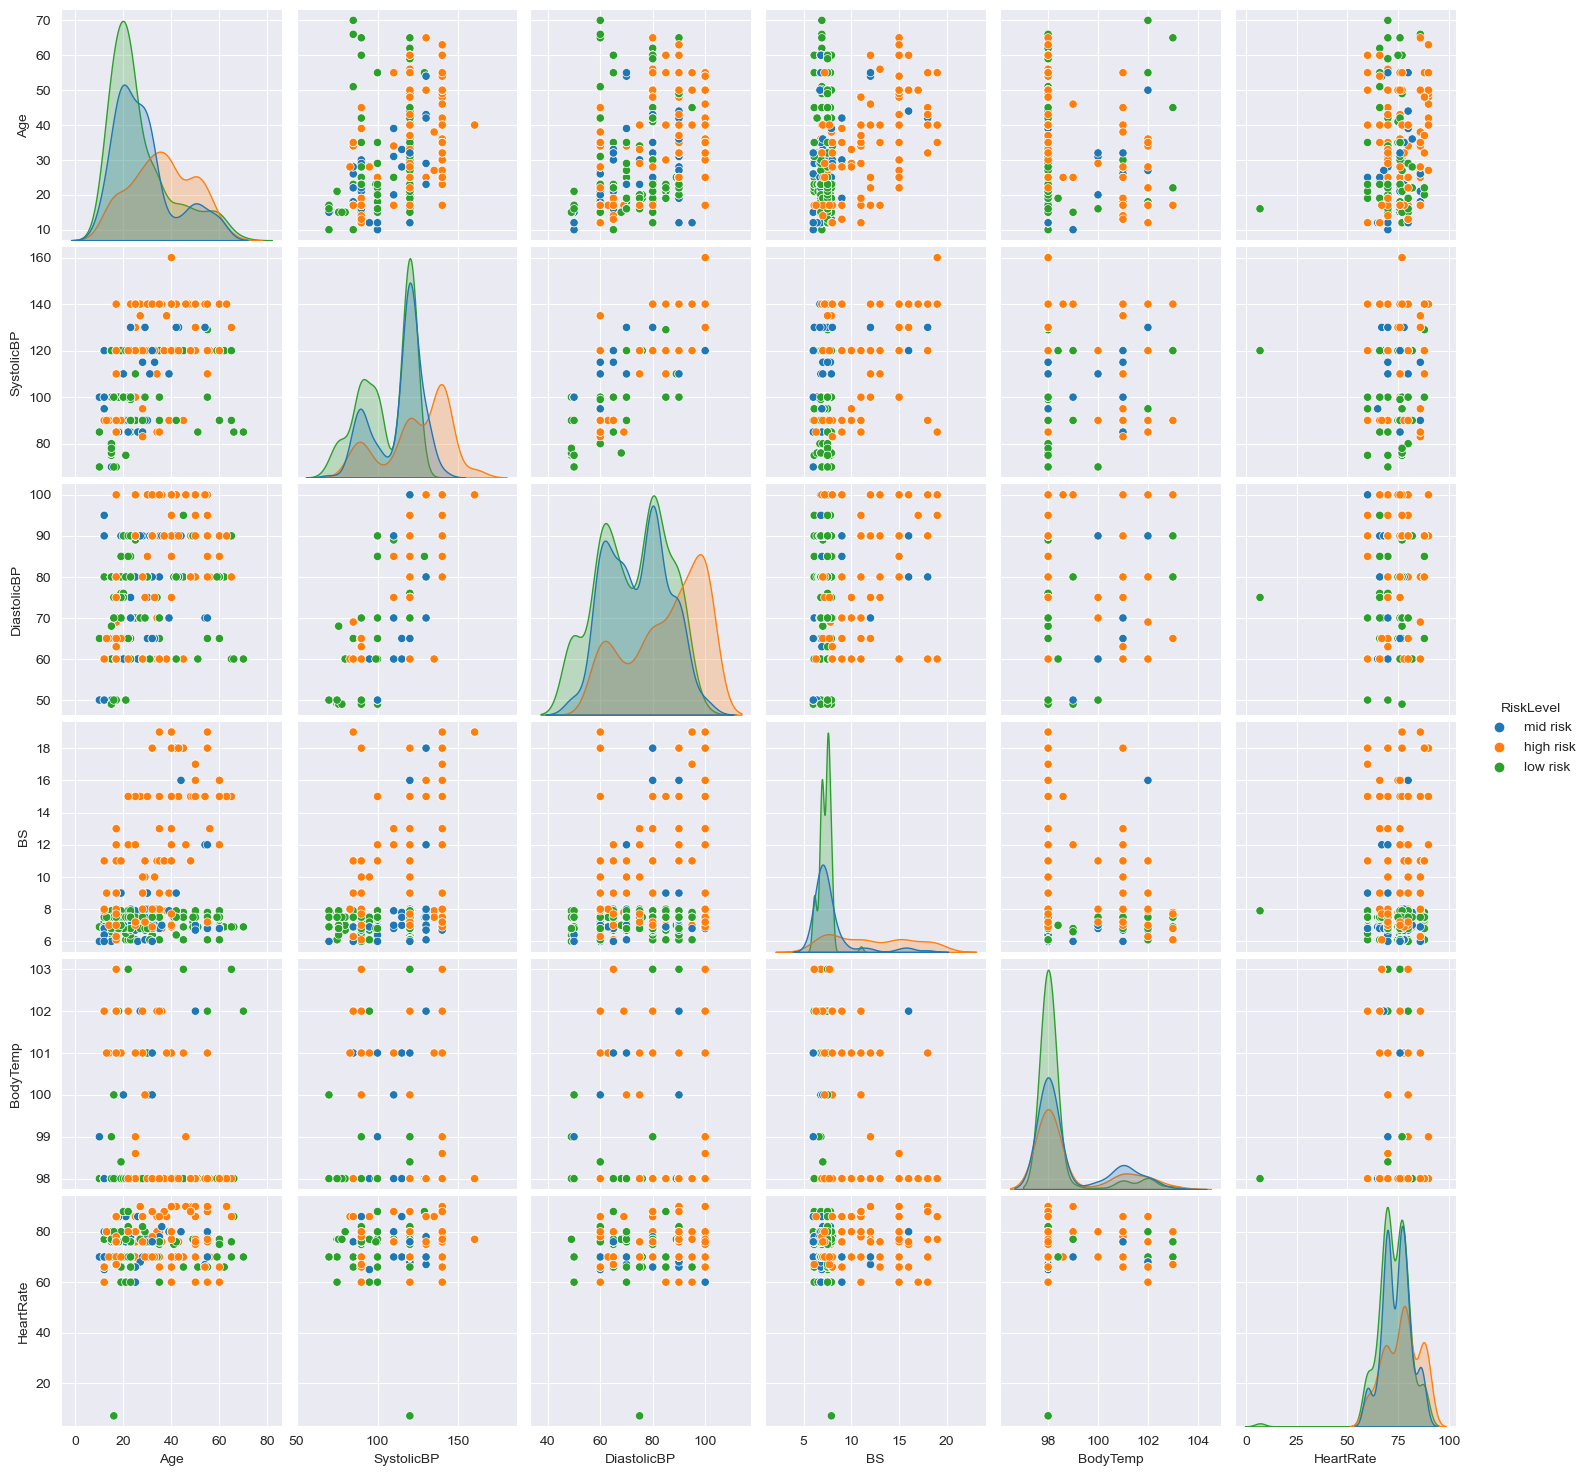

In [7]:
# Pairplot
import seaborn as sns
sns.set_style('darkgrid')
cols_to_plot = list(risk_df.columns)
cols_to_plot.remove("index_col")
sns.pairplot(risk_df[cols_to_plot], diag_kws={'color':'#03C988'}, hue="RiskLevel", hue_order=["mid risk", "high risk", "low risk"])

First, looking at the kernel density plots (diagonal), there are a few variables where risk levels differed across the health condition spectrum. For diastolic blood pressure (BP), the peak density for high risk patients falls in higher range of diastolic BP (around 100) while most low/mid risk patients have lower diastolic BP (60-80). Similar pattern exists in systolic BP although the differentiation is less pronounced (two smaller peaks of high risk are at same systolic BP level with mid/low risk). Also, most patients with high risk are older in age (most around 40 years old) than patients with mid/low risk (peak density at 20 years old).

To sum up for kernel density plots, visually there are bigger differences in health conditions between high and mid/low group versus between mid and low group.

Next, the pairplot showed that there might be correlations between diastolicBP/systolicBP, age/diastolicBP, age/systolicBP while for other pairs of variables there seems to be no strong relationships. To confirm, Pearson correlation coefficient values between every two variables were calculated.

In [8]:
# Check for multicolinearity
# Calculate Pearson correlation coefficient values (r).

corr = risk_df[cols_to_plot].corr()
corr

C:\Users\Jessica M\AppData\Local\Temp\ipykernel_25400\2915981060.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = risk_df[cols_to_plot].corr()


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate
Age,1.000000,0.416045,0.398026,0.473284,-0.255323,0.079798
SystolicBP,0.416045,1.000000,0.787006,0.425172,-0.286616,-0.023108
DiastolicBP,0.398026,0.787006,1.000000,0.423824,-0.257538,-0.046151
BS,0.473284,0.425172,0.423824,1.000000,-0.103493,0.142867
BodyTemp,-0.255323,-0.286616,-0.257538,-0.103493,1.000000,0.098771
HeartRate,0.079798,-0.023108,-0.046151,0.142867,0.098771,1.000000


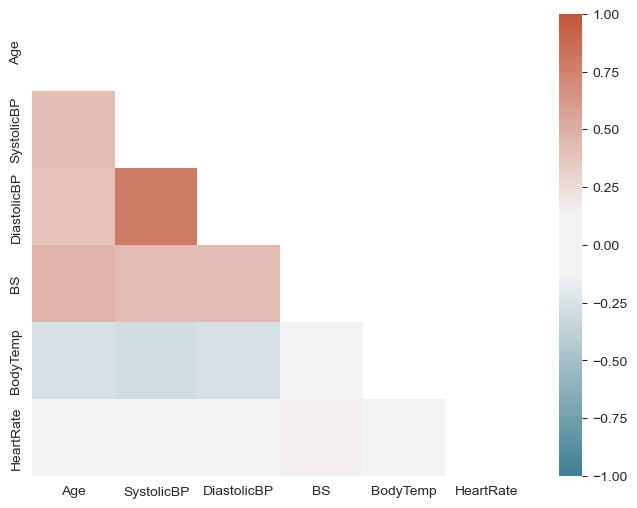

In [9]:
# Create a heatmap of correlations.

masking = np.triu(np.ones_like(corr, dtype=bool))
figure, axis = plt.subplots(figsize=(8, 6))  
c_map = sns.diverging_palette(220, 20, as_cmap=True, sep=34)  
c_map.set_bad('white')  
sns.heatmap(corr, mask=masking, cmap=c_map, vmin=-1, vmax=1)  
axis.tick_params(axis='both', which='major', labelsize=10)

Decision Tree Classification
Since there is no multicolinearity, all independent variables can be used for data modeling. Decision tree is a type of supervised learning algorithms, suitable for both continuous and categorical output variables. Here decision tree classification is used to illustrate the impact of health conditions on risk level (categorical output

In [10]:
# Convert risk levels (categorical data) to numbers. 

risk_df_riskNum = pd.read_sql(''' SELECT Age, SystolicBP, DiastolicBP, BS, BodyTemp, HeartRate, 
                                          CASE
                                            WHEN RiskLevel = "high risk" THEN 2
                                            WHEN RiskLevel = "mid risk" THEN 1
                                            WHEN RiskLevel = "low risk" THEN 0
                                          END AS RiskLevel
                                  FROM risk_tb
                                  ;
                              ''', con)
risk_df_riskNum

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
0,25,130,80,15.0,98.0,86,2
1,35,140,90,13.0,98.0,70,2
2,29,90,70,8.0,100.0,80,2
3,30,140,85,7.0,98.0,70,2
4,35,120,60,6.1,98.0,76,0
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,2
1010,55,120,90,18.0,98.0,60,2
1011,35,85,60,19.0,98.0,86,2
1012,43,120,90,18.0,98.0,70,2


In [12]:
# Independent variables (drop index_col).

X = risk_df_riskNum.iloc[:, :-1].values
print("X:\n", X)

# Dependent variable.
y = risk_df_riskNum.iloc[:, -1:].values
print("y:\n", y)

X:
 [[ 25. 130.  80.  15.  98.  86.]
 [ 35. 140.  90.  13.  98.  70.]
 [ 29.  90.  70.   8. 100.  80.]
 ...
 [ 35.  85.  60.  19.  98.  86.]
 [ 43. 120.  90.  18.  98.  70.]
 [ 32. 120.  65.   6. 101.  76.]]
y:
 [[2]
 [2]
 [2]
 ...
 [2]
 [2]
 [1]]


Accuracy: 0.7093596059113301


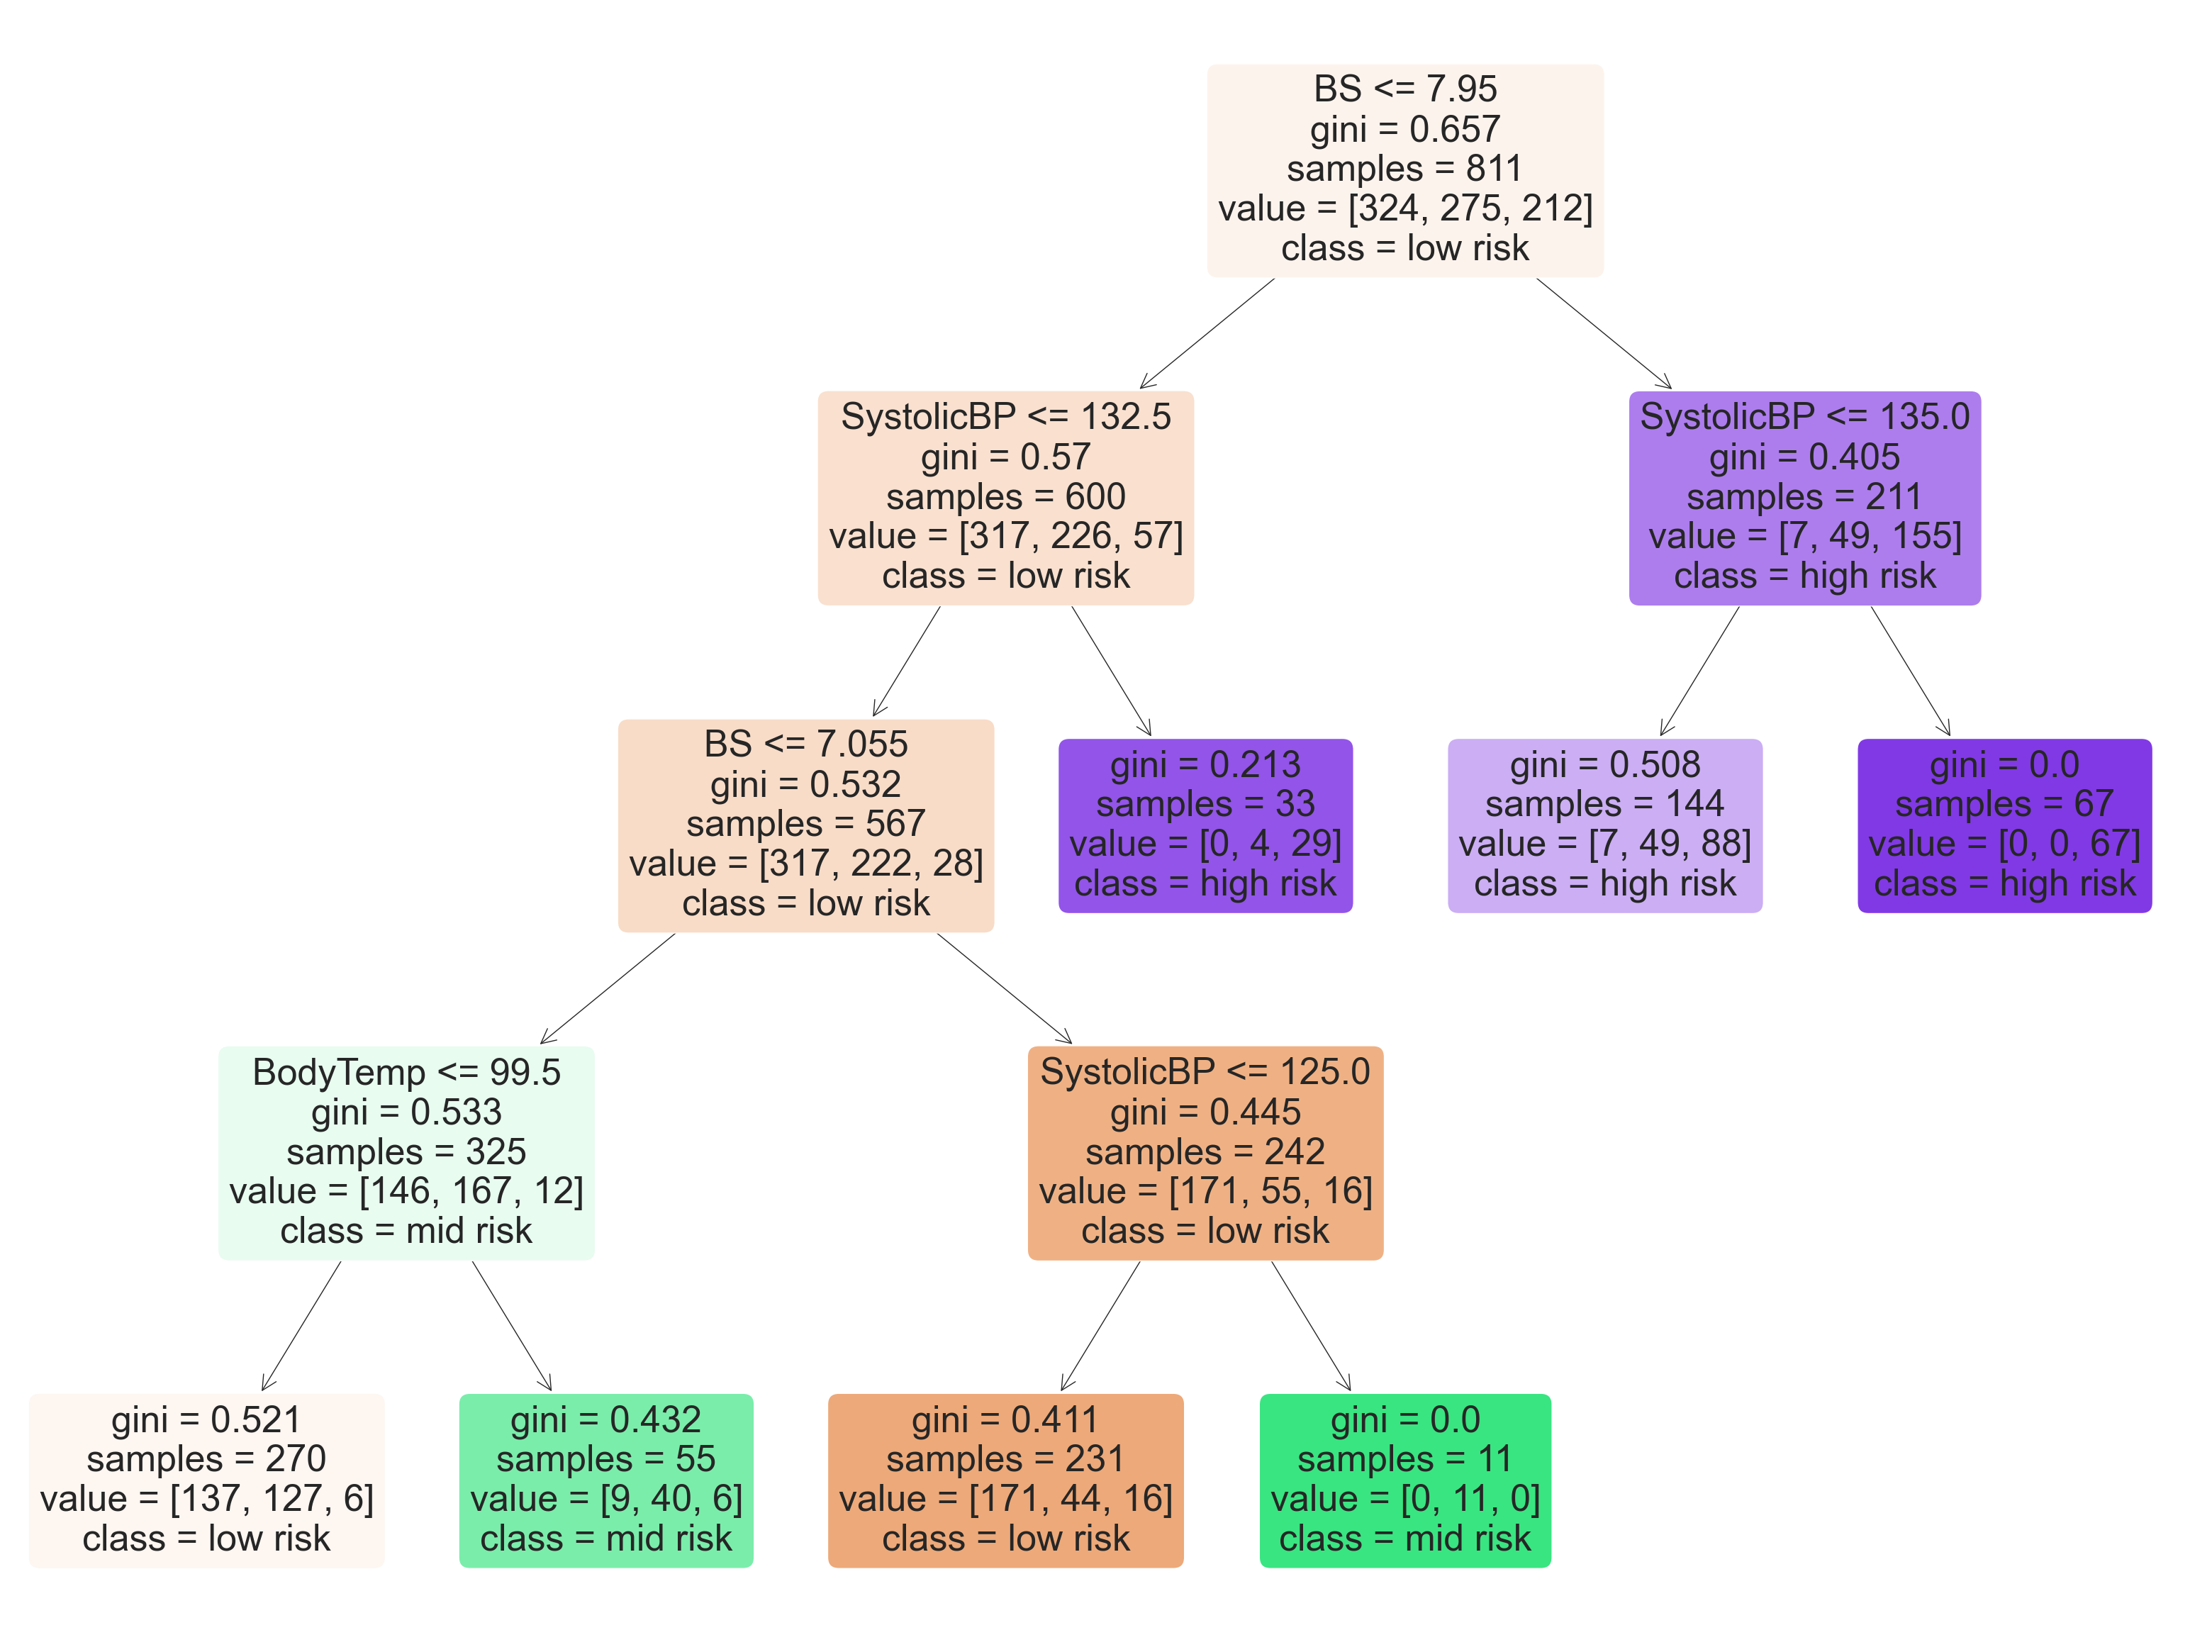

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Split the dataset.

X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2, random_state=30)

# Fit data. 

clf = DecisionTreeClassifier(max_depth=4, min_samples_split=150)
clf = clf.fit(X_train, y_train)

# Check classifier accuracy.

accuracy = clf.score(X_test, y_test)
print("Accuracy:", accuracy)

# Plot the tree.

feature_names = ["Age", "SystolicBP", "DiastolicBP", "BS", "BodyTemp", "HeartRate"]
class_names=['low risk','mid risk', "high risk"]
plt.figure(figsize=(40,30))
tree.plot_tree(clf,feature_names=feature_names, class_names=['low risk','mid risk', "high risk"],filled=True,rounded=True)
plt.show()

Gini refers to the Gini index or Gini coefficient, which is a statistical measure commonly used to quantify the level of  inequality within a distribution of data and variables other variables. It is named after the Italian statistician Corrado Gini.

The Gini coefficient is a number between 0 and 1, where 0 represents perfect equality (i.e., everyone has an equal share) and 1 represents maximum inequality (i.e., a single individual has all the share, while others have none). It is often depicted as a Lorenz curve, which is a graphical representation of the cumulative distribution function of the ranked values.

In the context of healthcare inequality, the Gini coefficient measures the deviation from a perfectly equal distribution. It is calculated as the area between the Lorenz curve and the line of perfect equality (a straight line connecting the origin and the top-right corner of the plot) divided by the total area under the line of perfect equality.

A Gini coefficient of 0 indicates perfect equality, where everyone has the same income or wealth, while a Gini coefficient of 1 represents extreme inequality, where one individual has all the income or wealth, and others have none.

The Gini coefficient is widely used in economics, sociology, and other fields to study and compare income inequality, and various  indicators. It provides a concise measure to assess the inequality within a population and can be used to track changes in inequality over time or compare inequality across different targets and variables  

**Healthcare**: It can measure the disparity in health outcomes - as used here. 




Hyperparameters (max_depth, min_samples_split) were adjusted reasonably to achieve an accuracy of over 70% for the classification. Key factors that can predict risk level are Blood sugar (BS), systolicBP, and BodyTemp.

BS was at root note. When BS > 7.95 and SystolicBP > 135.0 the risk level is most likely high (Gini impurity of 0.0 in the leaf node; all 67 training instances were sorted into high risk); otherwise when SystolicBP ≤ 135.0, the outcome is also possibly high risk (gini = 0.508).

When BS ≤ 7.95, the predicted outcome is mostly low/mid risk except when systolicBP > 132.5 (gini = 0.213, predicted outcome is high risk). When BS > 0.7055 and systolicBP ≤ 125.0, the prediction is low risk; otherwise when systolicBP > 125 the prediction is mid risk (gini = 0.0). Alternatively, when BS ≤ 7.055 and BodyTemp > 99.5, the prediction is also mid risk.

This model is most accurate for patients that are pre-menopausal adults, adolescents, or menopausal adults (when combined accounts for 91.7% of total number of patients). Since post-menopausal adults, children and older adults have a much smaller sample size in comparison, it is possible that above preditions do not apply to these age groups.